In [1]:
# 1. import packages and classes

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.interpolate import griddata, interp1d
from geoalchemy2.shape import to_shape

from app.db.database import get_session
from app.db.models import (
    HourlyActual, NoonForecast, PredictionModelGridSubset, ModelRunGridSubsetPrediction, PredictionModelRunTimestamp)
from sqlalchemy import extract

In [2]:
# 2. provide data

session = get_session()

PENTICTON = 328
PENTICTON_LAT = 49.5183333
PENTICTON_LONG = -119.5533333

STATION_CODE = PENTICTON
STATION_LONGITUDE = PENTICTON_LONG
STATION_LATITUDE = PENTICTON_LAT


In [3]:
# 2.1 actuals

# get the actuals, at noon (that's 20h00 utc)
actuals_query = session.query(HourlyActual)\
    .filter(HourlyActual.station_code==STATION_CODE)\
    .filter(extract('hour', HourlyActual.weather_date) == 20)\
    .filter(HourlyActual.temp_valid == True)

print("ACTUALS")
for actual in actuals_query:
    print('{actual.weather_date} {actual.temperature}'.format(actual=actual))
actual_x = [actual.weather_date for actual in actuals_query]
actual_y = [actual.temperature for actual in actuals_query]


ACTUALS
2020-09-02 20:00:00+00:00 24.1
2020-09-03 20:00:00+00:00 24.9
2020-09-04 20:00:00+00:00 24.6
2020-09-05 20:00:00+00:00 29.3
2020-09-06 20:00:00+00:00 28.4
2020-09-07 20:00:00+00:00 22.3
2020-09-08 20:00:00+00:00 20.3
2020-09-09 20:00:00+00:00 21.1


In [4]:
# 2.2 forecasts

# get the forecaster forecasts
forecast_query = session.query(NoonForecast)\
    .filter(NoonForecast.station_code==STATION_CODE)\
    .filter(NoonForecast.temp_valid==True)\
    .order_by(NoonForecast.weather_date, NoonForecast.created_at)

print("FORECASTS:")
for forecast in forecast_query:
    print('{forecast.weather_date} {forecast.temperature} ({forecast.created_at})'.format(forecast=forecast))
forecast_x = [forecast.weather_date for forecast in forecast_query]
forecast_y = [forecast.temperature for forecast in forecast_query]
    

FORECASTS:
2020-08-12 20:00:00+00:00 18.0 (2020-08-11 23:41:18.696953+00:00)
2020-08-13 20:00:00+00:00 25.0 (2020-08-12 23:30:14.748427+00:00)
2020-08-14 20:00:00+00:00 29.0 (2020-08-12 23:30:14.748427+00:00)
2020-08-14 20:00:00+00:00 29.0 (2020-08-13 23:30:25.044577+00:00)
2020-08-15 20:00:00+00:00 32.0 (2020-08-12 23:30:14.748427+00:00)
2020-08-15 20:00:00+00:00 32.0 (2020-08-13 23:30:25.044577+00:00)
2020-08-16 20:00:00+00:00 34.0 (2020-08-12 23:30:14.748427+00:00)
2020-08-16 20:00:00+00:00 34.0 (2020-08-13 23:30:25.044577+00:00)
2020-08-19 20:00:00+00:00 33.0 (2020-08-18 23:31:20.832892+00:00)
2020-08-20 20:00:00+00:00 30.0 (2020-08-18 23:31:20.832892+00:00)
2020-08-20 20:00:00+00:00 28.0 (2020-08-19 23:30:59.111933+00:00)
2020-08-21 20:00:00+00:00 29.0 (2020-08-18 23:31:20.832892+00:00)
2020-08-21 20:00:00+00:00 29.0 (2020-08-19 23:30:59.111933+00:00)
2020-08-21 20:00:00+00:00 24.0 (2020-08-20 23:30:55.635034+00:00)
2020-08-22 20:00:00+00:00 26.0 (2020-08-19 23:30:59.111933+00:00)

In [5]:
# 2.3 model data

print("MODEL DATA:")

grid = session.query(PredictionModelGridSubset).\
        filter(PredictionModelGridSubset.geom.ST_Contains(
            'POINT({longitude} {latitude})'.format(longitude=STATION_LONGITUDE, latitude=STATION_LATITUDE))).first()


poly = to_shape(grid.geom)
points = list(poly.exterior.coords)[:-1]

target_coordinate = [(STATION_LONGITUDE, STATION_LATITUDE)]


print(poly)
print(points)

# The global model doesn't have a noon - so things get a bit more complicated.
# Get the values around noon (18, 21)
query = session.query(ModelRunGridSubsetPrediction, PredictionModelRunTimestamp)\
    .filter(PredictionModelRunTimestamp.id == ModelRunGridSubsetPrediction.prediction_model_run_timestamp_id)\
    .filter(ModelRunGridSubsetPrediction.prediction_model_grid_subset_id==grid.id)\
    .filter(extract('hour', ModelRunGridSubsetPrediction.prediction_timestamp).in_((18, 21)))\
    .order_by(ModelRunGridSubsetPrediction.prediction_timestamp)


# remove any predictions more than 3 days into the future
predictions = []
for prediction, model_run in query:
    # there's surely a way to do this in sql alchemy, but not time for that now!
    delta = prediction.prediction_timestamp - model_run.prediction_run_timestamp
    if delta.days <= 3:
        predictions.append((prediction, model_run.prediction_run_timestamp))

# interpolate between 18utc at 21utc so that we have a noon values
noon_predictions = []
before = None
for prediction, prediction_run_timestamp in predictions:
    if prediction.prediction_timestamp.hour == 18:
        before = prediction
    if prediction.prediction_timestamp.hour == 21:
        # x-axis is the timestamp
        x_axis = (before.prediction_timestamp.timestamp(), prediction.prediction_timestamp.timestamp())
        # y-axis is the temperature at 18 and the temperature at 21
        y_axis = [
            [before.tmp_tgl_2[0], prediction.tmp_tgl_2[0]],
            [before.tmp_tgl_2[1], prediction.tmp_tgl_2[1]],
            [before.tmp_tgl_2[2], prediction.tmp_tgl_2[2]],
            [before.tmp_tgl_2[3], prediction.tmp_tgl_2[3]]
        ]
        noon = before.prediction_timestamp.replace(hour=20)
        function = interp1d(x_axis, y_axis, kind='linear')
        # interpolate by time
        interpolated_noon_value = function(noon.timestamp())
        # interpolate by location
        interpolated_value = griddata(points, interpolated_noon_value, target_coordinate, method='linear')
        
        noon_prediction = {
            "prediction_run_timestamp": prediction_run_timestamp,
            "prediction_timestamp": noon,
            "tmp_tgl_2": interpolated_value
        }
        noon_predictions.append(noon_prediction)
predictions = None

# now, we'd rather just have a single noon value for now, so we're going to interpolate
# between the four points.


for prediction in noon_predictions:
    print('run: {} ; timestamp: {} : tmp_tgl_2 : {}'.format(
        prediction['prediction_run_timestamp'].strftime("%Y-%m-%d "),
        prediction['prediction_timestamp'],
        prediction['tmp_tgl_2']))
    
prediction_x = [prediction['prediction_timestamp'] for prediction in noon_predictions]
prediction_y = [prediction['tmp_tgl_2'] for prediction in noon_predictions]
    

MODEL DATA:
POLYGON ((-119.625 49.575, -119.475 49.575, -119.475 49.425, -119.625 49.425, -119.625 49.575))
[(-119.62499999999997, 49.575), (-119.47499999999998, 49.575), (-119.47499999999998, 49.425000000000004), (-119.62499999999997, 49.425000000000004)]
run: 2020-07-27  ; timestamp: 2020-07-27 20:00:00+00:00 : tmp_tgl_2 : [28.54675121]
run: 2020-07-27  ; timestamp: 2020-07-27 20:00:00+00:00 : tmp_tgl_2 : [28.59829542]
run: 2020-07-28  ; timestamp: 2020-07-28 20:00:00+00:00 : tmp_tgl_2 : [28.20312135]
run: 2020-07-27  ; timestamp: 2020-07-28 20:00:00+00:00 : tmp_tgl_2 : [28.29869965]
run: 2020-07-27  ; timestamp: 2020-07-28 20:00:00+00:00 : tmp_tgl_2 : [28.35933924]
run: 2020-07-28  ; timestamp: 2020-07-28 20:00:00+00:00 : tmp_tgl_2 : [28.24234705]
run: 2020-07-28  ; timestamp: 2020-07-29 20:00:00+00:00 : tmp_tgl_2 : [27.75442552]
run: 2020-07-27  ; timestamp: 2020-07-29 20:00:00+00:00 : tmp_tgl_2 : [27.74804834]
run: 2020-07-29  ; timestamp: 2020-07-29 20:00:00+00:00 : tmp_tgl_2 : [

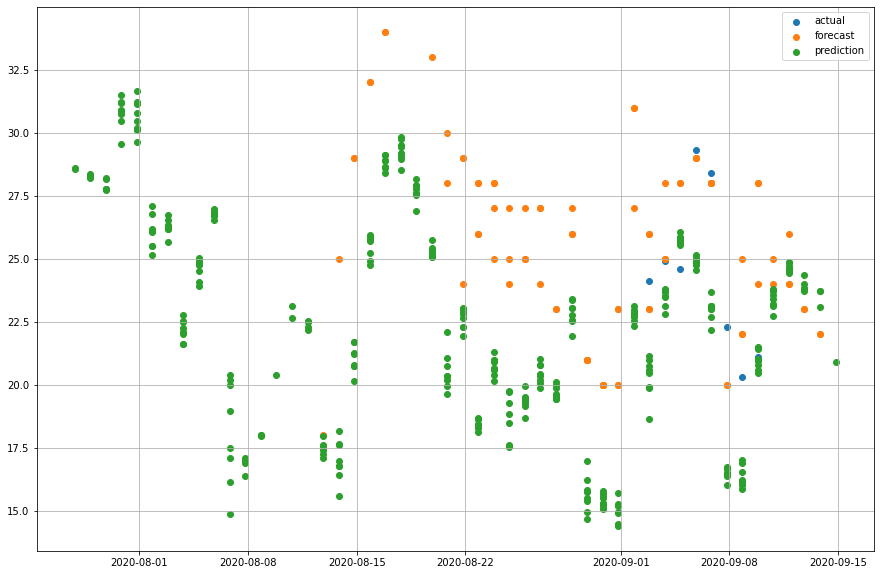

In [6]:
# 6. plot the results

fix, ax = plt.subplots(figsize=(15,10))


# TODO: you were here!
ax.scatter(actual_x, actual_y, label='actual')
ax.scatter(forecast_x, forecast_y, label='forecast')
ax.scatter(prediction_x, prediction_y, label='prediction')

ax.legend()
ax.grid(True)

plt.show()